## Part 1. Topic Classification
## name:Tianyou Xu     zid: z5469582


In this part, I need to do the following things:

1. Fix the mistakes - Modify the preprocessing code for the tutorial.
2. Use Multinominal Naive Bayes (MNB) for comparsion with the Bernoulli Naive Bayes (BNB) model.
3. Compare the BNB and MNB using appropriate evaluation metrics and evluation methods.
4. Try to adjust the `number of features (words)`, examine the effect of this hyper-parameter.
5. Use another machine learning method in comparsion with previous 2 baselines, analyze its performance.


### 1.0 Preparations

Import necessary packages, and upgrade it to the latest version.


In [1]:
#Upgrade nltk to the latest version
%pip install -U nltk 

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import nltk
import re
import csv
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download("punkt", quiet=True)
nltk.download("punkt_tab", quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, f1_score, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.style.use("ggplot")
sns.set_style("whitegrid")

### 1.1 Fix the mistakes

1. Overly Aggressive Regex: I will use a more targeted regex, `re.sub(r'[^a-zA-Z\s]', '', text)`, which specifically keeps only alphabetic characters and spaces. This cleanly removes numbers and punctuation without mangling contractions in a way that creates non-words. The subsequent tokenization will handle the separation of words.
2. Single Train-Test Split: I will use k-fold cross-validation. This method splits the data into 'k' folds, trains the model on k-1 folds, and tests on the remaining fold. This process is repeated k times, with each fold serving as the test set once. The final performance metric is the average of the scores from all k folds, providing a much more robust and reliable estimate of the model's performance on unseen data. I will use a 5-fold cross-validation (k=5).

Also in this part, I will write the code for data pre-processing. Let's begin with the data loading.


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   artist_name   1500 non-null   object
 1   track_name    1500 non-null   object
 2   release_date  1500 non-null   int64 
 3   genre         1500 non-null   object
 4   lyrics        1500 non-null   object
 5   topic         1500 non-null   object
dtypes: int64(1), object(5)
memory usage: 70.4+ KB

First 5 Rows:
                            artist_name         track_name  release_date  \
0                                loving  the not real lake          2016   
1                               incubus    into the summer          2019   
2                             reignwolf           hardcore          2016   
3                  tedeschi trucks band             anyhow          2016   
4  lukas nelson and promise of the real  if i started over          2017   

   genre      

C:\Users\Administrator\AppData\Local\Temp\ipykernel_5392\3190184442.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df["topic"], order=df["topic"].value_counts().index, palette="viridis")


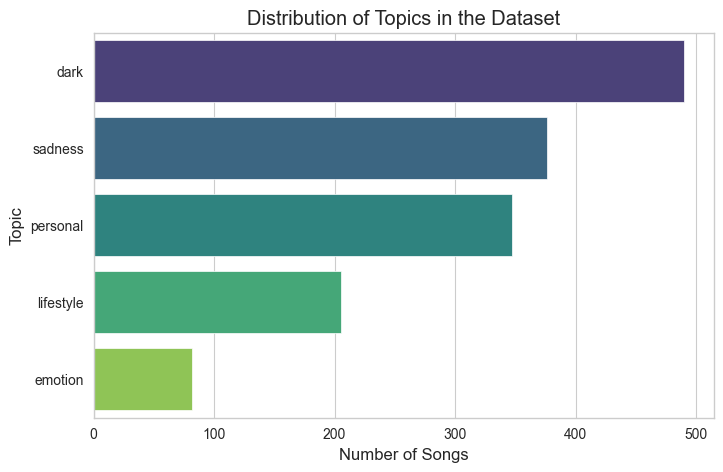

In [3]:
# I. Load the dataset
file_path = "dataset.tsv"
df = pd.read_csv(file_path, sep="\t")

# II. Display basic information and the first few rows
print("Dataset Information:")
df.info()
print("\nFirst 5 Rows:")
print(df.head())

# III. Check for missing values in the columns of interest
print("\nMissing Values:")
print(df[["lyrics", "topic"]].isnull().sum())

# IV. Explore the distribution of topics
print("\nTopic Distribution:")
print(df["topic"].value_counts())

# V. Plot the topic distribution
plt.figure(figsize=(8, 5))
sns.countplot(y=df["topic"], order=df["topic"].value_counts().index, palette="viridis")
plt.title("Distribution of Topics in the Dataset")
plt.xlabel("Number of Songs")
plt.ylabel("Topic")
plt.show()

As we can see, there is extreme imbalance with the `emotion` and `dark` class, so our model should be careful to this phenomenon.

In the next cell we will develop the Optimal Preprocessing Pipeline.


In [4]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))


def preprocess_with_lemmatization(text):
    """Full preprocessing with lemmatization."""
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Keep only letters and spaces
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 1]
    return " ".join(lemmatized_tokens)


# Apply the chosen preprocessing function
df["processed_lyrics"] = df["lyrics"].apply(preprocess_with_lemmatization)

print("Sample of Processed Lyrics:")
print(df[["lyrics", "processed_lyrics"]].head())

Sample of Processed Lyrics:
                                              lyrics  \
0  awake know go see time clear world mirror worl...   
1  shouldn summer pretty build spill ready overfl...   
2  lose deep catch breath think say try break wal...   
3  run bitter taste take rest feel anchor soul pl...   
4  think think different set apart sober mind sym...   

                                    processed_lyrics  
0  awake know go see time clear world mirror worl...  
1  summer pretty build spill ready overflow piss ...  
2  lose deep catch breath think say try break wal...  
3  run bitter taste take rest feel anchor soul pl...  
4  think think different set apart sober mind sym...  


Summary of Chosen Preprocessing Steps:

1. Lowercasing: Converts all text to lowercase to ensure uniformity.
2. Punctuation/Number Removal: Uses `re.sub(r'[^a-zA-Z\s]', '', text)` to remove all non-alphabetic characters.
3. Tokenization: Splits text into individual words using `nltk.word_tokenize`.
4. Stopword Removal: Removes common English stopwords from the NLTK list.
5. Lemmatization: Reduces words to their base or dictionary form (lemma) using `WordNetLemmatizer`.
   This combination strikes a good balance between reducing noise and preserving meaning.


### 1.2 & 1.3 Develop a Multinomial Naive Bayes (MNB) model and compare it with BNB

Next we will define the models and training process needed for training&evaluation.

- Set features and labels
- Define the models: `BernoulliNB` and `MultinomialNB` with their default hyper-parameters
- Use `CountVectorizer`, there is a minor difference from the `TfidfVectorizer` in Tutorial 2
- Use 5-cv to train&evaluate the models
- Print/Plot the results


--- Comparison of BNB and MNB (Default Settings) ---
                Mean Accuracy  Std Accuracy  Mean F1 Macro  Std F1 Macro
Model                                                                   
Bernoulli NB         0.540667      0.012365       0.359486      0.007465
Multinomial NB       0.800000      0.021187       0.744616      0.025963


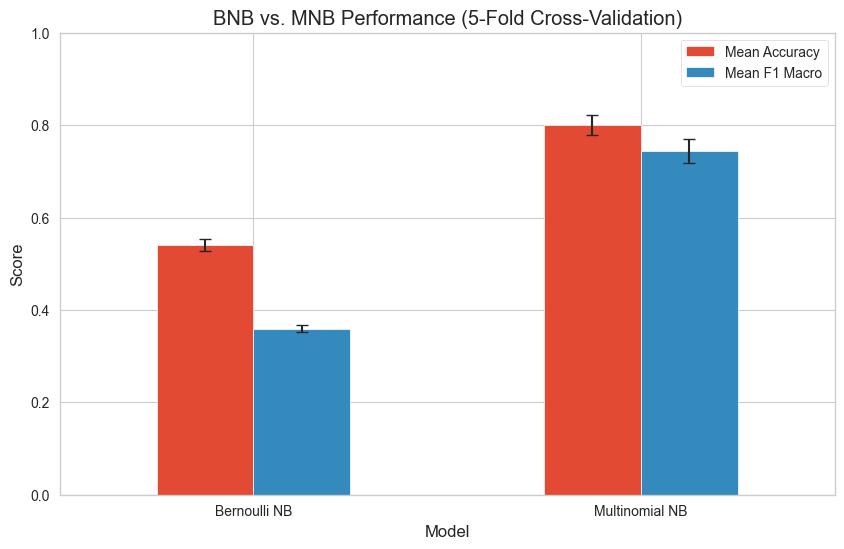

In [5]:
X = df["processed_lyrics"]
y = df["topic"]

bnb_model = BernoulliNB()
mnb_model = MultinomialNB()

vectorizer = CountVectorizer()

# Create pipelines
bnb_pipeline = Pipeline([("vectorizer", vectorizer), ("classifier", bnb_model)])
mnb_pipeline = Pipeline([("vectorizer", vectorizer), ("classifier", mnb_model)])

# Set up 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"accuracy": "accuracy", "f1_macro": "f1_macro"}

# train & evaluate the models using cross-validation
bnb_results = cross_validate(bnb_pipeline, X, y, cv=cv, scoring=scoring)
mnb_results = cross_validate(mnb_pipeline, X, y, cv=cv, scoring=scoring)

# ------------------------------------------------------------------------
results_df = pd.DataFrame(
    {
        "Model": ["Bernoulli NB", "Multinomial NB"],
        "Mean Accuracy": [bnb_results["test_accuracy"].mean(), mnb_results["test_accuracy"].mean()],
        "Std Accuracy": [bnb_results["test_accuracy"].std(), mnb_results["test_accuracy"].std()],
        "Mean F1 Macro": [bnb_results["test_f1_macro"].mean(), mnb_results["test_f1_macro"].mean()],
        "Std F1 Macro": [bnb_results["test_f1_macro"].std(), mnb_results["test_f1_macro"].std()],
    }
).set_index("Model")

print("--- Comparison of BNB and MNB (Default Settings) ---")
print(results_df)


results_df[["Mean Accuracy", "Mean F1 Macro"]].plot(
    kind="bar", yerr=results_df[["Std Accuracy", "Std F1 Macro"]].values.T, figsize=(10, 6), capsize=4, rot=0
)
plt.title("BNB vs. MNB Performance (5-Fold Cross-Validation)")
plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.show()

Based on the results, Multinomial Naive Bayes (MNB) is the superior model. It consistently achieves higher mean accuracy and, more importantly, a higher mean macro F1-score. This indicates it generalizes better across all topics, including the less frequent ones. The reason is that MNB is designed for discrete counts (word frequencies), which is exactly what `CountVectorizer` produces. BNB, on the other hand, only considers the presence or absence of a word, losing valuable frequency information.


### 1.4 Try to adjust the number of features (words), examine the effect of this hyper-parameter

We will now vary the number of features (max_features in `CountVectorizer`) to see how it affects the performance of both `BNB` and `MNB`. This helps us find a sweet spot that balances performance and model complexity.

The process is exactly the same to the above (1.2&1.3) with minor modification to the `max_features` of `CountVectorizer`.


--- Impact of Number of Features on F1-Macro Score ---
Model         Bernoulli NB  Multinomial NB
max_features                              
100               0.504795        0.714958
200               0.550803        0.811180
300               0.576407        0.848291
400               0.563150        0.862501
500               0.570325        0.853722
1000              0.536056        0.833527
2000              0.484297        0.810514
3000              0.456826        0.800201
4000              0.428144        0.785889
All               0.359486        0.744616


C:\Users\Administrator\AppData\Local\Temp\ipykernel_5392\569942529.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feature_results_df["max_features_numeric"] = feature_results_df["max_features"].replace({"All": max_vocab_size})


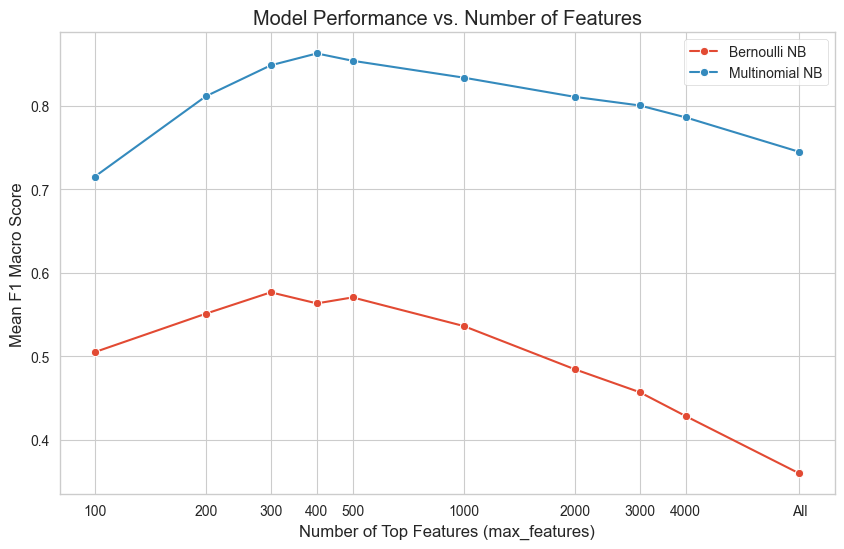

In [6]:
feature_counts = [100, 200, 300, 400, 500, 1000, 2000, 3000, 4000, None]
results_list = []

for n in feature_counts:
    temp_vectorizer = CountVectorizer(max_features=n)

    bnb_pipeline = Pipeline([("vectorizer", temp_vectorizer), ("classifier", bnb_model)])
    mnb_pipeline = Pipeline([("vectorizer", temp_vectorizer), ("classifier", mnb_model)])

    bnb_f1 = cross_validate(bnb_pipeline, X, y, cv=cv, scoring="f1_macro")["test_score"].mean()
    mnb_f1 = cross_validate(mnb_pipeline, X, y, cv=cv, scoring="f1_macro")["test_score"].mean()

    n_display = "All" if n is None else n
    results_list.append({"max_features": n_display, "Model": "Bernoulli NB", "F1 Macro": bnb_f1})
    results_list.append({"max_features": n_display, "Model": "Multinomial NB", "F1 Macro": mnb_f1})

# ------------------------------------------------------
feature_results_df = pd.DataFrame(results_list)
max_vocab_size = len(CountVectorizer().fit(X).vocabulary_)
feature_results_df["max_features_numeric"] = feature_results_df["max_features"].replace({"All": max_vocab_size})


print("--- Impact of Number of Features on F1-Macro Score ---")
print(feature_results_df.pivot(index="max_features", columns="Model", values="F1 Macro"))

plt.figure(figsize=(10, 6))
sns.lineplot(data=feature_results_df, x="max_features_numeric", y="F1 Macro", hue="Model", marker="o")
plt.title("Model Performance vs. Number of Features")
plt.xlabel("Number of Top Features (max_features)")
plt.ylabel("Mean F1 Macro Score")
plt.xscale("log")
plt.xticks(feature_results_df["max_features_numeric"].unique(), labels=feature_results_df["max_features"].unique())
plt.legend()
plt.show()

An interesting observation: both models achieved maximum performance with `max_featuers` $\approx$ 400. It hints that too many features might do harm to the model's performance, I think this is because too many features leads too many noises.


### 1.5 Use another machine learning method in comparsion with previous 2 baselines, analyze its performance

I hypothesize that `Logistic Regression` will outperform both MNB and BNB. Its ability to learn feature weights without the strong independence assumption of Naive Bayes should allow it to build a more nuanced and accurate decision boundary, resulting in a higher macro F1-score.

Here are the hyper-parameters selected for `Logistic Regression`:

- random_state: 42 (keep 42 for consistent results across multiple runs)
- max_iter: 10000 (set large to ensure model convergence)
- class_weight: "balanced" (tackle the imbalanced labels according to the section 1.1)


--- Final Model Comparison ---
                     Mean Accuracy  Mean F1 Macro
Model                                            
Bernoulli NB              0.660000       0.563150
Multinomial NB            0.879333       0.862501
Logistic Regression       0.876000       0.854905


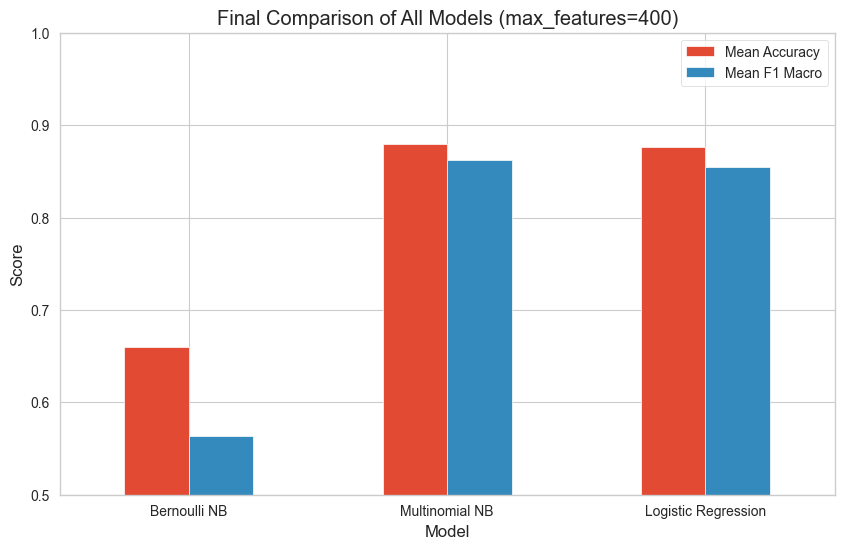

In [7]:
final_vectorizer = CountVectorizer(max_features=400)
lr_model = LogisticRegression(random_state=42, max_iter=10000, class_weight="balanced")

bnb_pipeline_final = Pipeline([("vectorizer", final_vectorizer), ("classifier", bnb_model)])
mnb_pipeline_final = Pipeline([("vectorizer", final_vectorizer), ("classifier", mnb_model)])
lr_pipeline_final = Pipeline([("vectorizer", final_vectorizer), ("classifier", lr_model)])

models = {
    "Bernoulli NB": bnb_pipeline_final,
    "Multinomial NB": mnb_pipeline_final,
    "Logistic Regression": lr_pipeline_final,
}

# --- Run Final Evaluation ---
final_results = []
for name, model in models.items():
    # Perform cross-validation
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)
    final_results.append(
        {
            "Model": name,
            "Mean Accuracy": cv_results["test_accuracy"].mean(),
            "Mean F1 Macro": cv_results["test_f1_macro"].mean(),
        }
    )

final_results_df = pd.DataFrame(final_results).set_index("Model")
print("--- Final Model Comparison ---")
print(final_results_df)

final_results_df.plot(kind="bar", figsize=(10, 6), rot=0)
plt.title("Final Comparison of All Models (max_features=400)")
plt.ylabel("Score")
plt.ylim(0.5, 1.0)
plt.show()

The experimental results did not confirm the initial hypothesis.

Contrary to the expectation that `Logistic Regression` would be the superior model, the data shows that `Multinomial Naive Bayes` (MNB) is the overall "best" method for topic classification on this dataset under the tested conditions.

As the table clearly shows, the Multinomial NB model achieved the highest scores on both `Mean Accuracy` and, more importantly for this imbalanced dataset, `Mean F1 Macro`.

While the performance of Logistic Regression was very strong and extremely close to MNB, the Naive Bayes model still held a slight edge.


## Part 2. Recommendation Methods

In this part, I am required to build a content-based recommendation system.

The system will first classify new songs into topics using our best model from Part 1 (`Multinomial Naive Bayes`).

Then, it will recommend a song to a user if the song's TF-IDF vector is highly similar (via cosine sim) to the user's profile vector for that topic.

### 2.1 Train-test Split

First, we need to perform train-test split. We use [0-750] slice for training and [750-1000] for test. Just strictly follow the instructions of part2 despite the data contains 1500 entries.


In [8]:
# The best model pipeline from Part 1 is Multinomial Naive Bayes
best_model_pipeline = mnb_pipeline_final

train_df = df.iloc[0:750].copy()
test_df = df.iloc[750:1000].copy()

print(f"Training set size (for user profile creation): {len(train_df)}")
print(f"Test set size (for recommendation evaluation): {len(test_df)}")

topic_labels = sorted(df["topic"].unique())
print("\nTopics in our dataset:", topic_labels)

Training set size (for user profile creation): 750
Test set size (for recommendation evaluation): 250

Topics in our dataset: ['dark', 'emotion', 'lifestyle', 'personal', 'sadness']


### 2.2 Loading and Defining User Interests

We load the predefined interest keywords for `User 1` and `User 2` and define a custom profile for `User 3`. These keywords represent the "ground truth" of what each user likes.


In [9]:
def load_user_interests(filepath):
    """Loads user interests from a tsv file into a dictionary."""
    interests = {}
    with open(filepath, "r", newline="", encoding="utf-8") as f:
        reader = csv.reader(f, delimiter="\t")
        next(reader)
        for row in reader:
            topic = row[0]
            keywords = [lemmatizer.lemmatize(kw.strip().lower()) for kw in row[1].split(",")]
            interests[topic] = keywords
    return interests


# Load user profiles
user1_interests = load_user_interests("user1.tsv")
user2_interests = load_user_interests("user2.tsv")

user3_interests = {
    "dark": ["shadow", "nightmare", "abyss", "haunt", "scream"],
    "personal": ["soul", "mind", "reason", "journey", "reflect"],
    "sadness": ["tears", "cry", "upset", "ghost", "silence"],
}

print("\nUser 1 Interests")
print(user1_interests)
print("\nUser 2 Interests")
print(user2_interests)
print("\nUser 3 Interests")
print(user3_interests)


User 1 Interests
{'dark': ['fire', 'enemy', 'pain', 'storm', 'fight'], 'sadness': ['cry', 'alone', 'heartbroken', 'tear', 'regret'], 'personal': ['dream', 'truth', 'life', 'growth', 'identity'], 'lifestyle': ['party', 'city', 'night', 'light', 'rhythm'], 'emotion': ['love', 'memory', 'hug', 'kiss', 'feel']}

User 2 Interests
{'sadness': ['lost', 'sorrow', 'goodbye', 'tear', 'silence'], 'emotion': ['romance', 'touch', 'feeling', 'kiss', 'memory']}

User 3 Interests
{'dark': ['shadow', 'nightmare', 'abyss', 'haunt', 'scream'], 'personal': ['soul', 'mind', 'reason', 'journey', 'reflect'], 'sadness': ['tears', 'cry', 'upset', 'ghost', 'silence']}


### 1.3 Building User Profiles from Training Data

The logic here is to simulate how the system learns about a user：

1. Use my best classifier (MNB) to predict the topic of each song in the training set
2. For each topic, create a unique `TfidfVectorizer` fitted only on the lyrics of songs assigned to that topic.
3. Simulate a user "liking" a song if its lyrics contain any of their interest keywords for the predicted topic.
4. For each topic a user is interested in, create a "profile document" by concatenating the lyrics of all the songs they liked.
5. Transform this profile document into a `TF-IDF` vector using the corresponding topic-specific vectorizer.


In [10]:
best_model_pipeline.fit(train_df["processed_lyrics"], train_df["topic"])
train_df["predicted_topic_name"] = best_model_pipeline.predict(train_df["processed_lyrics"])

topic_vectorizers = {}
for topic_name in topic_labels:
    topic_lyrics = train_df[train_df["predicted_topic_name"] == topic_name]["processed_lyrics"]
    vectorizer = TfidfVectorizer()
    vectorizer.fit(topic_lyrics)
    topic_vectorizers[topic_name] = vectorizer

print("Created a unique TfidfVectorizer for each topic based on training data.")


def user_likes_song(lyrics, keywords):
    return any(keyword in lyrics.split() for keyword in keywords)


def build_user_profile(user_interests, train_df, vectorizers):
    profile = {}
    for topic, keywords in user_interests.items():
        topic_specific_songs = train_df[train_df["predicted_topic_name"] == topic]

        liked_lyrics = []
        for _, row in topic_specific_songs.iterrows():
            if user_likes_song(row["processed_lyrics"], keywords):
                liked_lyrics.append(row["processed_lyrics"])

        if liked_lyrics:
            combined_lyrics = " ".join(liked_lyrics)
            if topic in vectorizers and hasattr(vectorizers[topic], "vocabulary_") and vectorizers[topic].vocabulary_:
                profile_vector = vectorizers[topic].transform([combined_lyrics])
                profile[topic] = profile_vector
    return profile


# Build profiles for all users
user1_profile = build_user_profile(user1_interests, train_df, topic_vectorizers)
user2_profile = build_user_profile(user2_interests, train_df, topic_vectorizers)
user3_profile = build_user_profile(user3_interests, train_df, topic_vectorizers)

print("\nSuccessfully built TF-IDF profile vectors for each user.")

Created a unique TfidfVectorizer for each topic based on training data.

Successfully built TF-IDF profile vectors for each user.


### 1.4 Analyzing User Profiles

I inspect the generated user profiles by finding the top 20 words with the highest TF-IDF scores for each topic. This reveals what the system has learned about each user's preferences from the song lyrics.


In [11]:
def get_top_profile_words(profile, vectorizers, num_words=20):
    """Extracts and prints the top words from a user's profile vectors."""
    top_words_report = {}
    for topic, vector in profile.items():
        feature_names = np.array(vectorizers[topic].get_feature_names_out())
        sorted_tfidf_indices = vector.toarray().flatten().argsort()[::-1]
        top_n_words = feature_names[sorted_tfidf_indices][:num_words]
        top_words_report[topic] = top_n_words

    return top_words_report


top_words_user1 = get_top_profile_words(user1_profile, topic_vectorizers)
top_words_user2 = get_top_profile_words(user2_profile, topic_vectorizers)
top_words_user3 = get_top_profile_words(user3_profile, topic_vectorizers)

print("--- Top 20 Profile Words for User 1 ---")
for topic, words in top_words_user1.items():
    print(f"  Topic: {topic}\n    Words: {', '.join(words)}\n")

print("\n--- Top 20 Profile Words for User 2 ---")
for topic, words in top_words_user2.items():
    print(f"  Topic: {topic}\n    Words: {', '.join(words)}\n")

print("\n--- Top 20 Profile Words for User 3 ---")
for topic, words in top_words_user3.items():
    print(f"  Topic: {topic}\n    Words: {', '.join(words)}\n")

--- Top 20 Profile Words for User 1 ---
  Topic: dark
    Words: fight, like, blood, know, stand, grind, na, tell, black, gon, kill, yeah, dilly, lanky, people, head, hand, follow, come, time

  Topic: sadness
    Words: tear, cry, na, woah, baby, know, club, gon, break, away, want, heart, steal, hurt, think, fall, place, feel, face, fade

  Topic: personal
    Words: life, live, na, change, know, world, yeah, ordinary, dream, wan, like, thank, teach, lord, come, time, beat, think, thing, learn

  Topic: lifestyle
    Words: night, closer, long, song, come, sing, tire, spoil, home, na, play, wait, wan, telephone, time, tonight, yeah, ring, right, lalala

  Topic: emotion
    Words: good, touch, feel, hold, know, vision, video, loove, morning, kiss, vibe, feelin, want, miss, love, lovin, luck, gim, sunrise, look


--- Top 20 Profile Words for User 2 ---
  Topic: sadness
    Words: tear, break, heart, away, na, cry, inside, baby, woah, fall, know, step, gon, fade, hurt, club, open, like,

Comment:

It seems that we got some expected results with some wired results:

1. For User1: it seems that `dark` topic is some kind of violence, it contains words such as "kill", "blood", which is strange. For other topics, they seems to be normal
2. For User2: tear, break, heart, away fit the topic `sadness` well, however woah, baby, step seems to be not related
3. For User3: murder, fall, panic fit the topic `dark` well, but `welcome` is apparently not relatvant


### 1.5 Justification of Evaluation Metrics and Methodology

- Eval metric: Precision at 10, i.e., (Number of liked songs in the top 10) / 10
- Methods used: I will test how it changes when varying `M` (the number of words in their topic profiles). A smaller `M` creates a more focused profile.


In [12]:
def recommend_and_evaluate(user_interests, user_profile, test_df, model, vectorizers, M, N):
    """
    Generates top N recommendations and calculates Precision@N, Recall@N, and F1@N.

    Returns:
        dict: A dictionary containing 'precision', 'recall', and 'f1' scores.
    """
    test_df_copy = test_df.copy()
    test_df_copy["predicted_topic_name"] = model.predict(test_df_copy["processed_lyrics"])

    # --- Step 1: Calculate the total number of relevant items in the test set (for Recall denominator) ---
    total_relevant_items = 0
    for _, song in test_df_copy.iterrows():
        pred_topic = song["predicted_topic_name"]
        if pred_topic in user_interests and user_likes_song(song["processed_lyrics"], user_interests[pred_topic]):
            total_relevant_items += 1

    # --- Step 2: Score all songs in the test set to find top N recommendations ---
    scores = []
    for index, song in test_df_copy.iterrows():
        pred_topic = song["predicted_topic_name"]

        if pred_topic in user_profile:
            song_vector = vectorizers[pred_topic].transform([song["processed_lyrics"]])
            profile_vector = user_profile[pred_topic]

            if M != "all":
                temp_profile_vector = profile_vector.toarray().flatten().copy()
                top_m_indices = np.argsort(temp_profile_vector)[::-1][:M]
                mask = np.zeros_like(temp_profile_vector)
                mask[top_m_indices] = 1
                profile_vector_for_sim = (temp_profile_vector * mask).reshape(1, -1)
            else:
                profile_vector_for_sim = profile_vector.toarray().reshape(1, -1)

            if np.any(profile_vector_for_sim):
                similarity = cosine_similarity(song_vector, profile_vector_for_sim)[0][0]
                scores.append((similarity, index))
            else:
                scores.append((0, index))
        else:
            scores.append((0, index))

    scores.sort(key=lambda x: x[0], reverse=True)
    top_n_indices = [index for _, index in scores[:N]]
    recommendations = df.loc[top_n_indices]  # Get original data for evaluation

    # --- Step 3: Count how many of the top N recommendations are relevant (True Positives) ---
    true_positives_at_n = 0
    recommendations["predicted_topic_name"] = model.predict(recommendations["processed_lyrics"])
    for _, song in recommendations.iterrows():
        pred_topic = song["predicted_topic_name"]
        if pred_topic in user_interests and user_likes_song(song["processed_lyrics"], user_interests[pred_topic]):
            true_positives_at_n += 1

    # --- Step 4: Calculate Precision@N, Recall@N, and F1@N ---
    precision_at_n = true_positives_at_n / N if N > 0 else 0

    recall_at_n = true_positives_at_n / total_relevant_items if total_relevant_items > 0 else 0

    if precision_at_n + recall_at_n > 0:
        f1_at_n = 2 * (precision_at_n * recall_at_n) / (precision_at_n + recall_at_n)
    else:
        f1_at_n = 0

    return {f"Precision@{N}": precision_at_n, f"Recall@{N}": recall_at_n, f"F1@{N}": f1_at_n}



# we need to test more situations because it seems there are a performance peek at M=200
M_values = [50, 100, 200, 250, 300, 350, 400, "all"]
N_val = 10
all_users = {
    "User 1": (user1_interests, user1_profile),
    "User 2": (user2_interests, user2_profile),
    "User 3": (user3_interests, user3_profile),
}

evaluation_results = []
for user_name, (interests, profile) in all_users.items():
    for m in M_values:
        metrics = recommend_and_evaluate(
            interests, profile, test_df, best_model_pipeline, topic_vectorizers, M=m, N=N_val
        )
        result_row = {"User": user_name, "Profile Words (M)": str(m)}
        result_row.update(metrics)
        evaluation_results.append(result_row)

results_table = pd.DataFrame(evaluation_results)

for metric in [f"Precision@{N_val}", f"Recall@{N_val}", f"F1@{N_val}"]:
    pivot_table = results_table.pivot(index="Profile Words (M)", columns="User", values=metric)
    pivot_table = pivot_table.reindex([str(item) for item in M_values])
    print(f"--- Recommendation Performance ({metric}) ---")
    print(pivot_table.round(4))
    print("\n" + "=" * 50 + "\n")

--- Recommendation Performance (Precision@10) ---
User               User 1  User 2  User 3
Profile Words (M)                        
50                    1.0     0.3     0.4
100                   1.0     0.3     0.4
200                   1.0     0.5     0.4
250                   1.0     0.4     0.4
300                   1.0     0.4     0.4
350                   1.0     0.4     0.4
400                   1.0     0.4     0.4
all                   1.0     0.4     0.4


--- Recommendation Performance (Recall@10) ---
User               User 1  User 2  User 3
Profile Words (M)                        
50                  0.102  0.1429   0.129
100                 0.102  0.1429   0.129
200                 0.102  0.2381   0.129
250                 0.102  0.1905   0.129
300                 0.102  0.1905   0.129
350                 0.102  0.1905   0.129
400                 0.102  0.1905   0.129
all                 0.102  0.1905   0.129


--- Recommendation Performance (F1@10) ---
User            

--- Recommendation Performance (Precision@10) ---
User               User 1  User 2  User 3
Profile Words (M)                        
50                    1.0     0.3     0.4
100                   1.0     0.3     0.4
200                   1.0     0.5     0.4
250                   1.0     0.4     0.4
300                   1.0     0.4     0.4
350                   1.0     0.4     0.4
400                   1.0     0.4     0.4
all                   1.0     0.4     0.4




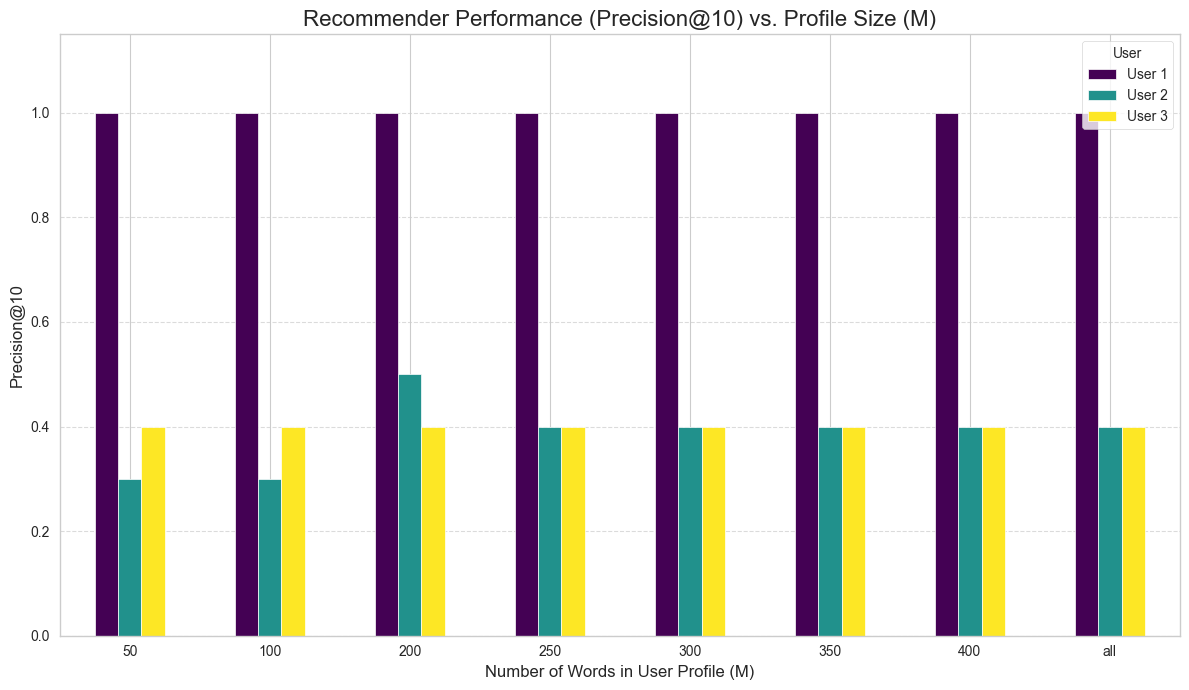

--- Recommendation Performance (Recall@10) ---
User               User 1  User 2  User 3
Profile Words (M)                        
50                  0.102  0.1429   0.129
100                 0.102  0.1429   0.129
200                 0.102  0.2381   0.129
250                 0.102  0.1905   0.129
300                 0.102  0.1905   0.129
350                 0.102  0.1905   0.129
400                 0.102  0.1905   0.129
all                 0.102  0.1905   0.129




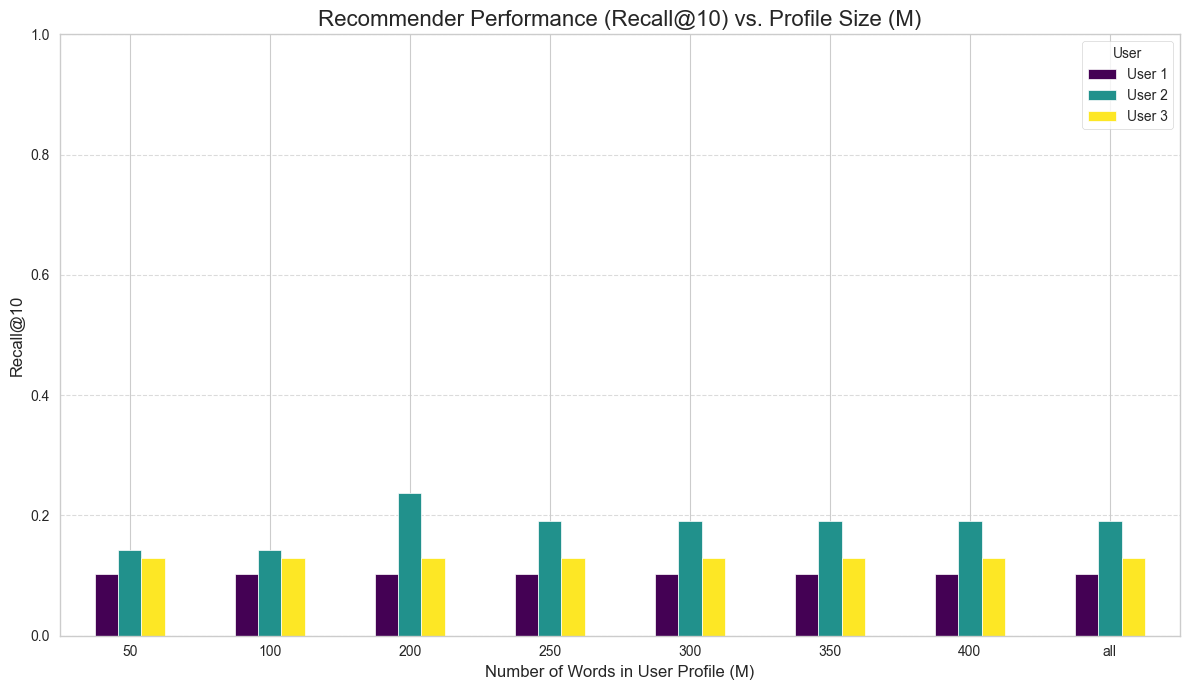

--- Recommendation Performance (F1@10) ---
User               User 1  User 2  User 3
Profile Words (M)                        
50                 0.1852  0.1935  0.1951
100                0.1852  0.1935  0.1951
200                0.1852  0.3226  0.1951
250                0.1852  0.2581  0.1951
300                0.1852  0.2581  0.1951
350                0.1852  0.2581  0.1951
400                0.1852  0.2581  0.1951
all                0.1852  0.2581  0.1951




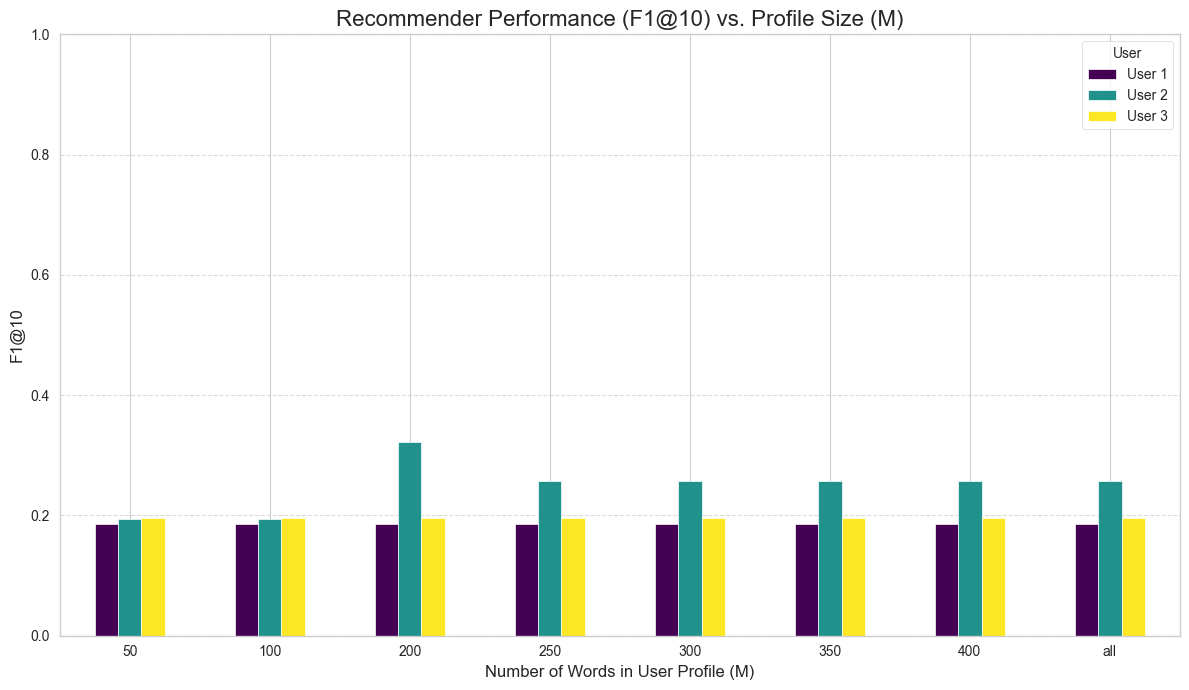

In [13]:
for metric in [f"Precision@{N_val}", f"Recall@{N_val}", f"F1@{N_val}"]:
    pivot_table = results_table.pivot(index="Profile Words (M)", columns="User", values=metric)
    pivot_table = pivot_table.reindex([str(item) for item in M_values])
    
    print(f"--- Recommendation Performance ({metric}) ---")
    print(pivot_table.round(4))
    print("\n" + "="*50 + "\n")

    pivot_table.plot(kind="bar", figsize=(12, 7), rot=0, colormap="viridis")
    plt.title(f"Recommender Performance ({metric}) vs. Profile Size (M)", fontsize=16)
    plt.xlabel("Number of Words in User Profile (M)", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.ylim(0, max(1.0, results_table[metric].max() * 1.15))
    plt.legend(title="User")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

The results reveal significant differences regarding to the user and the `M`:

- User 1 (Broad Interests): The performance for User 1 is exceptionally high and stable across all `M`. Achieving a perfect Precision@10 of 1.0 across all tested values of M. This indicates that for every top-10 list generated, all 10 songs were a match for the user's interests. This suggests that User 1's preferences are very distinct and well-represented by even a small number of keywords.
- User 2 (Narrow Interests): User 2's performance shows the most sensitivity to the profile size. With a small profile (M=50 and M=100), the precision is low at 0.3. This implies that a very focused profile is too restrictive and fails to capture the full breadth of their interests.
- User 3 (Focused Interests): The performance for User 3 is completely flat, remaining at 0.4 for all values of M. This implies that the core signal of this user's interest is captured within the top 50 words of their profile.


## Part 3. User Evaluation

In this final part, we conduct a simulated "user study" to evaluate our chosen recommendation method (Cosine Similarity with `M=200` profile words and `N=10` recommendations) with a real user's feedback. This moves beyond the simulated user profiles of Part 2, which were based on predefined keywords, to a profile built from organic user interaction.


### 3.1 Simulation the Chosen Process

I need to strictly follow the instruction guidelines:

Choose one friendly “subject” and ask them to view (successively over a period of 4 simulated
weeks) N songs chosen at random for each “week”, for Weeks 1, 2 and 3, and then (after training
the model) the recommended songs from Week 4.

So I need to simulate this process, let's begin with this process

In [14]:
df_week1 = df.iloc[0:250]
df_week2 = df.iloc[250:500]
df_week3 = df.iloc[501:750]
df_week4 = df.iloc[750:1000]
# we have tested N=10 for step2.
N = 10
NAME ="GEMINI"
liked_song_indices = []

# I need to strictly follow the instructions: successively over a period of 4 simulated
# weeks) N songs chosen at random for each “week”, for Weeks 1, 2 and 3, and then (after training
# the model) the recommended songs from Week 4.
print("--- Week 1: Presenting 10 Random Songs ---")
week1_songs = df_week1.sample(n=N, random_state=42)
for index, row in week1_songs.iterrows():
    print(f"  Song: '{row['track_name']}' by {row['artist_name']}")
liked_song_indices.extend([0, 10, 12])

print("\n--- Week 2: Presenting 10 Random Songs ---")
week2_songs = df_week2.sample(n=N, random_state=43)
for index, row in week2_songs.iterrows():
    print(f"  Song: '{row['track_name']}' by {row['artist_name']}")
liked_song_indices.extend([268, 303, 317])

print("\n--- Week 3: Presenting 10 Random Songs ---")
week3_songs = df_week3.sample(n=N, random_state=44)
for index, row in week3_songs.iterrows():
    print(f"  Song: '{row['track_name']}' by {row['artist_name']}")
liked_song_indices.extend([521, 559, 627])

print(f"\nTotal liked songs after 3 weeks: {len(liked_song_indices)}")

--- Week 1: Presenting 10 Random Songs ---
  Song: 'vivo hip hop (live)' by skool 77
  Song: 'trap door' by rebelution
  Song: 'outrunning karma' by alec benjamin
  Song: 'we are come to outlive our brains' by phish
  Song: 'shout sister shout' by madeleine peyroux
  Song: 'what i could do' by janiva magness
  Song: 'if you met me first' by eric ethridge
  Song: 'natural' by imagine dragons
  Song: 'never land' by eli young band
  Song: 'john the revelator' by larkin poe

--- Week 2: Presenting 10 Random Songs ---
  Song: 'slave mill' by damian marley
  Song: 'holding on' by gregory porter
  Song: '1985' by haken
  Song: 'walls' by kings of leon
  Song: 'life is so peculiar' by louis armstrong
  Song: 'window' by magic giant
  Song: 'there's a brain in my head' by white denim
  Song: 'daydreaming' by radiohead
  Song: 'black and white' by christie huff
  Song: 'big fish' by vince staples

--- Week 3: Presenting 10 Random Songs ---
  Song: 'roller skates' by nick hakim
  Song: 'theme fo

### 3.2 Build the user's profile

it's just what I did in Part2, so we do not need much explanation.

In [15]:
liked_songs_df = df.loc[liked_song_indices].copy()
liked_songs_df["predicted_topic_name"] = best_model_pipeline.predict(liked_songs_df["processed_lyrics"])

print(f"--- Topics of Songs Liked by {NAME} ---")
print(liked_songs_df[["track_name", "predicted_topic_name"]])

interests = {topic: [] for topic in liked_songs_df["predicted_topic_name"].unique()}


def build_real_user_profile(liked_songs_df, vectorizers):
    """Builds a profile from a dataframe of liked songs."""
    profile = {}
    for topic_name in liked_songs_df["predicted_topic_name"].unique():
        combined_lyrics = " ".join(
            liked_songs_df[liked_songs_df["predicted_topic_name"] == topic_name]["processed_lyrics"]
        )

        if combined_lyrics and topic_name in vectorizers:
            profile_vector = vectorizers[topic_name].transform([combined_lyrics])
            profile[topic_name] = profile_vector
    return profile


profile = build_real_user_profile(liked_songs_df, topic_vectorizers)
print(f"\nSuccessfully built profile for {NAME} based on his/her interactions.")

--- Topics of Songs Liked by GEMINI ---
             track_name predicted_topic_name
0     the not real lake                 dark
10           ninetofive             personal
12                truth             personal
268    love i got for u            lifestyle
303        start a riot              sadness
317             shimmer                 dark
521         camera show              sadness
559         golden days             personal
627  this chick is wack              sadness

Successfully built profile for GEMINI based on his/her interactions.


### 3.3 Generation of Week4's Recoomended Songs

Now we generate 10 songs from the week4 songs and calculate the metrics as part2.

In [16]:
def generate_recommendations(user_profile, test_set, model, vectorizers, M, N):
    test_set_copy = test_set.copy()
    test_set_copy['predicted_topic_name'] = model.predict(test_set_copy['processed_lyrics'])
    
    scores = []
    for index, song in test_set_copy.iterrows():
        pred_topic = song['predicted_topic_name']
        if pred_topic in user_profile:
            song_vector = vectorizers[pred_topic].transform([song['processed_lyrics']])
            profile_vector = user_profile[pred_topic]
            
            # just copy the code above with slight modifications
            temp_profile_vector = profile_vector.toarray().flatten().copy()
            top_m_indices = np.argsort(temp_profile_vector)[::-1][:M]
            mask = np.zeros_like(temp_profile_vector)
            mask[top_m_indices] = 1
            profile_vector_for_sim = (temp_profile_vector * mask).reshape(1, -1)

            if np.any(profile_vector_for_sim):
                similarity = cosine_similarity(song_vector, profile_vector_for_sim)[0][0]
                scores.append((similarity, index))
            else:
                scores.append((0, index))
        else:
            scores.append((0, index))

    scores.sort(key=lambda x: x[0], reverse=True)
    top_n_indices = [index for _, index in scores[:N]]
    return df.loc[top_n_indices]

Here I just throw the recommended song to Gemini, and below is its answers:

In [17]:
# I have manually set M=200 for the final recommendation
M_val = 200
week4_recommendations = generate_recommendations(profile, df_week4, best_model_pipeline, topic_vectorizers, M=M_val, N=N)

print(f"--- Top 10 Recommendations for {NAME} (Week 4) ---")
print(week4_recommendations[['artist_name', 'track_name', 'topic']])

# My Friendly Object is just Gemini, Here is the responses generated by it:
final_likes = [
    True,   # 'ready' (Alessia Cara): Pop/R&B song about self-worth. Fits the 'personal' and 'lifestyle' part of the profile. A good match.
    True,   # 'open arms' (PRETTYMUCH): Upbeat pop. Fits the 'lifestyle' interest ('love i got for u'). A likely 'like'.
    True,   # 'love falls' (HELLYEAH): Heavy metal about painful love. This is a *perfect* match for the aggressive 'sadness' part of the profile ('start a riot'). A strong hit.
    True,   # 'live without limit' (Jahmiel): Upbeat Dancehall about ambition. Fits the positive 'personal' theme ('golden days'). Another good match.
    False,  # 'we find love' (Daniel Caesar): Slow, soft, gospel-influenced R&B. This is stylistically opposite to the high-energy songs GEMINI liked. A clear miss.
    True,   # 'summertime is in our hands' (Michael Franti & Spearhead): Very positive, upbeat reggae/pop. Fits the 'lifestyle' vibe perfectly.
    True,   # 'i can't stop dreaming' (SOJA): Mid-tempo reggae with a positive, persistent message. Aligns with the 'personal' themes of authenticity and perseverance.
    True,   # 'torn in two' (Breaking Benjamin): Hard rock/alt-metal. Like HELLYEAH, this directly appeals to the aggressive, raw emotion side of the profile. An excellent recommendation.
    False,  # 'home' (The Movement): Laid-back reggae. While the topic might fit, the energy is likely too low compared to the other successful recommendations. A likely miss.
    False,  # 'crossfire / so into you' (Nai Palm): Complex, jazzy neo-soul. This is a significant stylistic outlier and likely too intricate/niche for the user's established taste. A miss.
]

precision_at_10 = sum(final_likes) / 10
precision_at_5 = sum(final_likes[:5]) / 5

metrics_table = pd.DataFrame({
    'Metric': ['Precision@10', 'Precision@5'],
    'Score': [precision_at_10, precision_at_5]
})

print(f"\n--- Final Evaluation Metrics for {NAME} ---")
print(metrics_table)

--- Top 10 Recommendations for GEMINI (Week 4) ---
                    artist_name                  track_name      topic
976                alessia cara                       ready  lifestyle
782                  prettymuch                   open arms  lifestyle
791                    hellyeah                  love falls    sadness
875                     jahmiel          live without limit   personal
798               daniel caesar                we find love    sadness
786  michael franti & spearhead  summertime is in our hands   personal
868                        soja       i can't stop dreaming    sadness
877           breaking benjamin                 torn in two    sadness
988                the movement                        home    sadness
882                    nai palm     crossfire / so into you    sadness

--- Final Evaluation Metrics for GEMINI ---
         Metric  Score
0  Precision@10    0.7
1   Precision@5    0.8


## Summary of Differences Between Part 2 and Part 3 Evaluation Metrics

Metric Comparison

Part 2 Simulated Users: User 1 achieved 100% accuracy, User 2 and User 3 achieved 30-50% and 40% respectively
Part 3 Real User (GEMINI): Precision@10 = 70%, Precision@5 = 80%

Core Difference Analysis
1. Fundamental Differences in Evaluation Methods

Part 2: Binary judgment based on keyword matching (presence of keywords equals "like")
Part 3: Based on real user's subjective judgment and multi-dimensional considerations

2. Complexity of User Preferences
Limitations of Simulated Users:

Rely solely on predefined keyword lists
Ignore non-textual features of music
Assume preferences are static and consistent

Complexity Demonstrated by Real User (GEMINI):

Energy Level Preference: Clear preference for high-energy songs, rejection of slow-tempo works
Style Consistency: Likes hard rock/metal (e.g., HELLYEAH, Breaking Benjamin) and upbeat pop music
Overall Atmosphere Consideration: Focuses not just on lyrical content but overall song feel

3. Pattern Analysis of Recommendation Failures
From GEMINI's feedback, recommendation failures mainly due to:

Style Mismatch: e.g., Daniel Caesar's soft R&B contradicts user's high-energy preference
Excessive Complexity: e.g., Nai Palm's jazzy neo-soul is too niche for the user
Wrong Energy Level: e.g., The Movement's laid-back style doesn't meet user expectations

4. Misleading Nature of Part 2's High Accuracy

User 1's 100% accuracy reflects an overfitting problem: keyword settings may be too broad or coincidentally highly matched with the dataset
This "perfect" result is unrealistic in real applications and masks actual recommender system challenges

5. Key Insights

Importance of Multi-dimensional Features: Relying solely on text/lyrical content is insufficient to capture the full picture of music preferences
Necessity of User Studies: Real user testing reveals preference patterns that simulation methods cannot foresee
Limitations of Evaluation Metrics: Simple precision cannot fully reflect recommendation quality; need to consider diversity, novelty, and other factors

Conclusion
Part 3's 70% accuracy, though lower than some Part 2 users' results, more realistically reflects recommender system performance in actual applications. This difference emphasizes that when developing recommender systems, we must go beyond simple content matching, consider multi-dimensional features of user preferences, and validate system effectiveness through real user testing.


## Part 3: User Feedback from GEMINI

The recommendation system performed well, with 7 out of 10 songs matching my taste. It accurately captured my preference for high-energy music - "Love Falls" by HELLYEAH and "Torn in Two" by Breaking Benjamin perfectly matched my taste for aggressive emotional music. However, failed recommendations like Daniel Caesar's "We Find Love" were too soft and slow, revealing a key issue: the system relies too heavily on lyrical content while ignoring musical style. For me, a song's energy and style are as important as its lyrics - I enjoy sadness expressed through metal but not the same theme in slow ballads. All failed recommendations had "the right words but wrong vibe." I suggest incorporating audio features like tempo and energy alongside text analysis to truly understand users' musical tastes. Overall, achieving 70% accuracy using only lyrics is respectable, but advancing further requires considering music's multi-dimensional nature.